# Importing packages

In [1]:
using Plots
using DifferentialEquations
using LaTeXStrings
using LinearAlgebra
using ModelingToolkit
using OrdinaryDiffEq
using DiffEqBiological
using Latexify
using Sundials

gr();

# Defining model as a reaction network with parameters

In [22]:
κS = 1
κF = 1
Γ = 1
n = 3
v = ( 5*10^(-3) * ( κF^(-2/3) * Γ^(-1/3) ) ) * 3600
δC = ( 1.6*10^(-3) * κF^(-2/3) ) * 3600
ρS = ( 1.6 * ( κF^(1/3) * Γ^(-1/3) ) ) * 3600
ρP = ( 6*10^(-4) * ( κF^(1/3) * Γ^(-1/3) ) ) * 3600
ρF = ( 3.5*10^(-3)*κS ) * 3600
δS = ( 0.2*10^(-3) ) * 3600
δP = ( 1*10^(-3) ) * 3600
δF = ( 5*10^(-3) ) * 3600

rnParam = [δS, δP, δF, δC, Γ, n, v, ρS, ρP, ρF, κS, κF]

rn = @reaction_network begin
    hillr(κ₁,ρ₁,F,n), ∅ --> S
    ρ₂, ∅ --> P
    hillr(S*Γ*P^2,ρ₃,κ₃,n), ∅ --> F
    2*δ₄*Γ, 2P + S --> ∅ 
    δ₁, S --> ∅
    δ₂, P --> ∅
    δ₃, F --> ∅
    v*P^2*S*Γ, ∅ --> P    
end δ₁ δ₂ δ₃ δ₄ Γ n v ρ₁ ρ₂ ρ₃ κ₁ κ₃;

┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\hmngu\.julia\packages\DiffEqJump\TfjIU\src\jumps.jl:48


Here, due to the limitations of Julia's inline mathematical expression in code, I have defined that:
- $\delta_1$ is the decay rate of SHH, or $\bar{\delta_S}$
- $\delta_2$ is the decay rate of patched receptors Ptc, or $\bar{\delta_P}$
- $\delta_3$ is the decay rate of FGF10, or $\bar{\delta_F}$
- $\delta_4$ is the decay rate of complex SHH-Ptc, or $\bar{\delta_C}$
- $\rho_1$ is the production rate of SHH, or $\bar{\rho_S}$
- $\rho_2$ is the production rate of patched receptors Ptc, or $\bar{\rho_P}$
- $\rho_3$ is the production rate of FGF10, or $\bar{\rho_F}$
- $\kappa_1$ is the Hill's constant of SHH, or $\bar{\kappa_S}$
- $\kappa_3$ is the Hill's constant of FGF10, or $\bar{\kappa_F}$

# DiffEq Mathematical Model

In [23]:
latexify(rn,  starred=true, cdot = false, clean= true, symbolic = true,field=:symfuncs)

L"\begin{align*}
\frac{dS(t)}{dt} =& \frac{\rho_1 F^{n}}{F^{n} + \kappa_1^{n}} - \frac{2 \delta_4 \Gamma}{2} P^{2} S - \delta_1 S \\
\frac{dP(t)}{dt} =& \rho_2 -2 \frac{2 \delta_4 \Gamma}{2} P^{2} S - \delta_2 P + v P^{2} S \Gamma \\
\frac{dF(t)}{dt} =& \frac{\rho_3 \kappa_3^{n}}{\kappa_3^{n} + \left( S \Gamma P^{2} \right)^{n}} - \delta_3 F
\end{align*}
"

# The Symbolic Jacobian Expression

In [24]:
latexify(jacobianexprs(rn), cdot=false)

L"\begin{equation}
\left[
\begin{array}{ccc}
 - \frac{2 \delta_4 \Gamma}{2} P^{2} - \delta_1 &  - 2 \delta_4 \Gamma P S & \frac{n \rho_1 F^{-1 + n}}{F^{n} + \kappa_1^{n}} - \frac{n \rho_1 F^{-1 + 2 n}}{\left( F^{n} + \kappa_1^{n} \right)^{2}} \\
-2 \frac{2 \delta_4 \Gamma}{2} P^{2} + v \Gamma P^{2} & -2 2 \delta_4 \Gamma P S - \delta_2 + 2 v \Gamma P S & 0 \\
\frac{\left(  - n \right) \kappa_3^{n} \rho_3 \left( \Gamma P^{2} S \right)^{n}}{S \left( \kappa_3^{n} + \left( \Gamma P^{2} S \right)^{n} \right)^{2}} & \frac{-2 n \kappa_3^{n} \rho_3 \left( \Gamma P^{2} S \right)^{n}}{P \left( \kappa_3^{n} + \left( \Gamma P^{2} S \right)^{n} \right)^{2}} &  - \delta_3 \\
\end{array}
\right]
\end{equation}
"

# Solving the reaction network as an ODE problem

### A random initial point

Consider picking (0.1, 0.1, 0.1), we will solve for the steady state given the parameters we currently have.

In [68]:
u0 = [0.1, 0.1, 0.1]
tspan = [0.0, 5.0]
odeProb = ODEProblem(rn, u0, tspan, rnParam)
ssProb = SteadyStateProblem(rn, u0, rnParam)

odeSol = solve(odeProb, AutoTsit5(Rosenbrock23()))
ssSol = solve(ssProb, DynamicSS(CVODE_BDF()),dt=1.0);

The steady state we found is:

In [69]:
ssSol

u: 3-element Array{Float64,1}:
 0.12726349892373956
 3.647262497966724
 0.11962280194505014

Ploting the concentrations over time

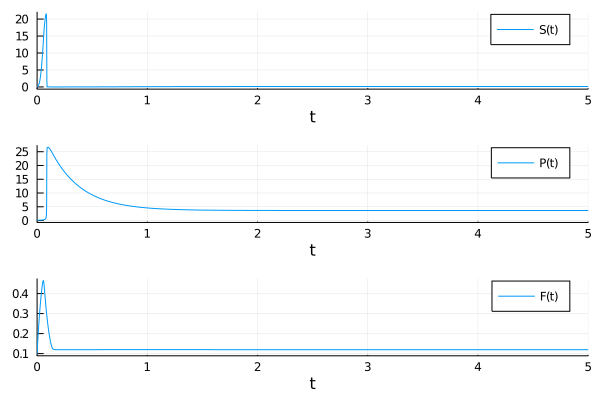

In [70]:
plot(odeSol, layout = (3,1))

Ploting the steady state space in 3D:

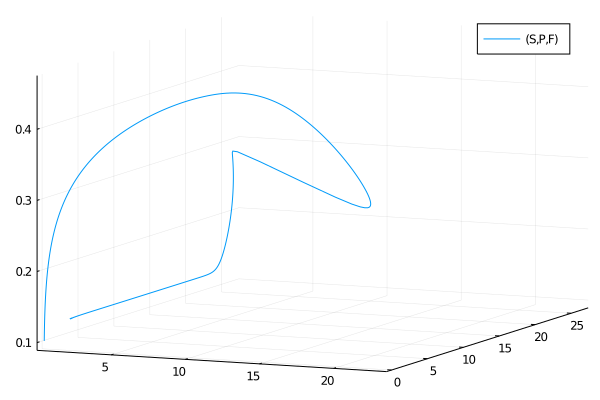

In [71]:
plot(odeSol,vars=(1,2,3),plotdensity=10000)

### Behavior of the model near the steady state

To examine the behavior of the steady state, we consider picking the initial point near the steady state we found

In [45]:
#u0 = [0.1272642106579746, 3.6472310383795565, 0.11962240351435512]
u0 = [0.12, 3.64, 0.12]
tspan = [0.0, 5.0]
odeProb = ODEProblem(rn, u0, tspan, rnParam)
ssProb = SteadyStateProblem(rn, u0, rnParam)

odeSol = solve(odeProb, AutoTsit5(Rosenbrock23()))
ssSol = solve(ssProb, DynamicSS(CVODE_BDF()),dt=1.0);

In [46]:
ssSol

u: 3-element Array{Float64,1}:
 0.12726414816928983
 3.6472288141414926
 0.11962237683462228

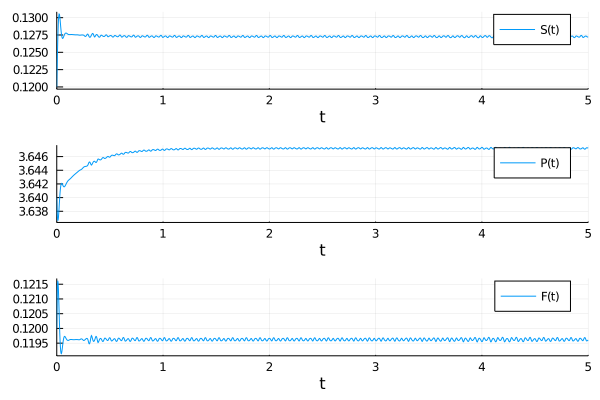

In [47]:
plot(odeSol, layout = (3,1))

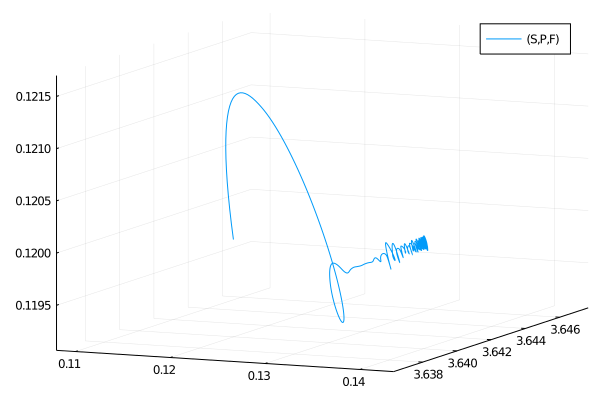

In [48]:
plot(odeSol,vars=(1,2,3),plotdensity=10000)

As we can see there are some oscillations near the end so we increase the number of decimals near the steady state to tol of $10^{-8}$

In [53]:
u0 = [0.12726421, 3.64723103, 0.11962240]
tspan = [0.0, 5.0]
odeProb = ODEProblem(rn, u0, tspan, rnParam)
ssProb = SteadyStateProblem(rn, u0, rnParam)

odeSol = solve(odeProb, AutoTsit5(Rosenbrock23()))
ssSol = solve(ssProb, DynamicSS(CVODE_BDF()),dt=1.0);

In [54]:
ssSol

u: 3-element Array{Float64,1}:
 0.12726423645201343
 3.647230183629223
 0.1196223918114193

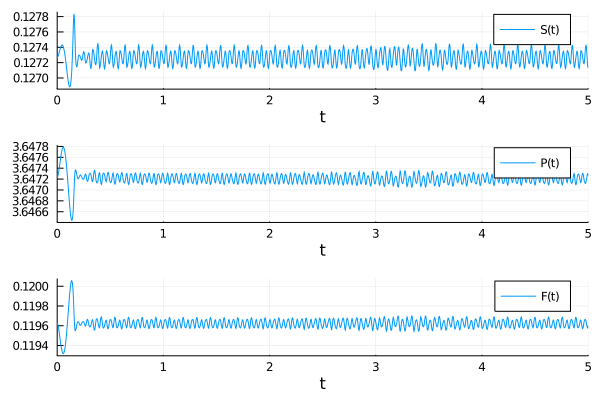

In [55]:
plot(odeSol, layout = (3,1))

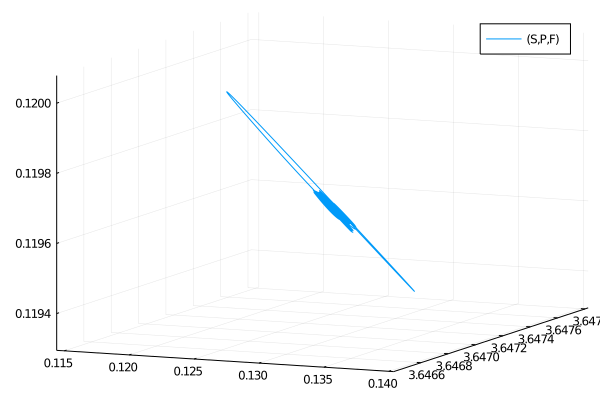

In [56]:
plot(odeSol,vars=(1,2,3),plotdensity=10000)

# Bifurcations

## Variation of decay rate of patched receptor, or $\bar{\delta_P}$

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological

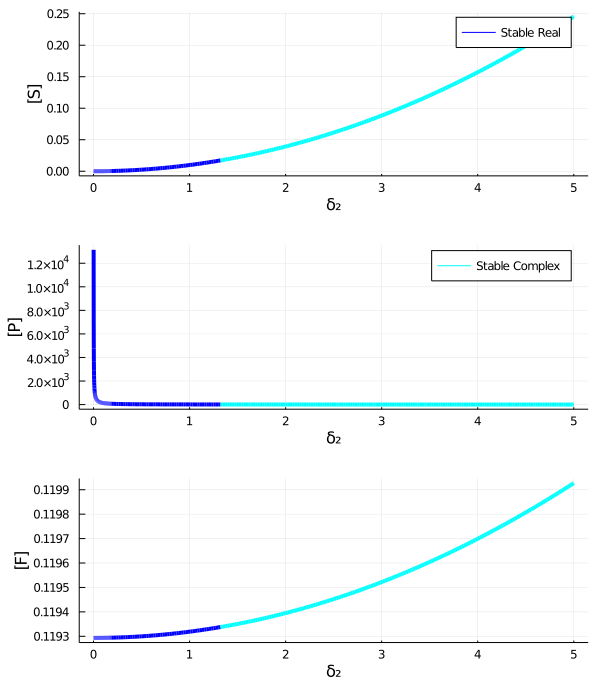

In [72]:
bif = bifurcations(rn, rnParam, :δ₂, (0.001,5.))
plt = plot(layout = (3,1), size = (600, 700))
plot!(plt, [[],[]],color=[:blue :cyan],label = ["Stable Real" "Stable Complex"])
plot!(plt[1], bif, 1, ylabel = "[S]")
plot!(plt[2], bif, 2, ylabel = "[P]")
plot!(plt[3], bif, 3, ylabel = "[F]")

## Variation of production rate of patched receptor, or $\bar{\rho_P}$

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological

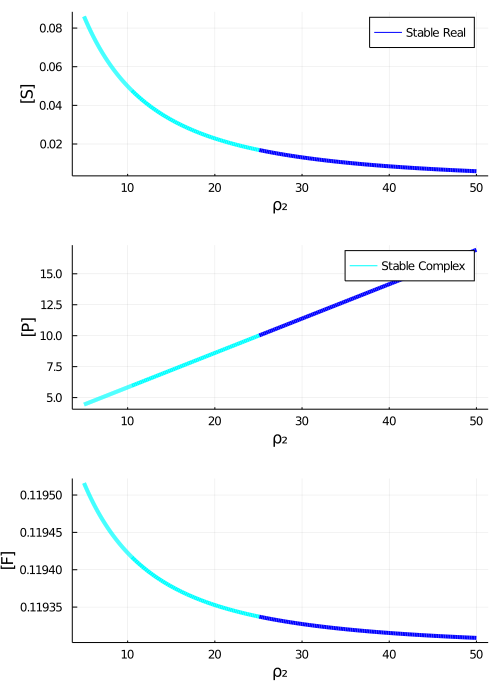

In [74]:
bif = bifurcations(rn, rnParam, :ρ₂, (5.0,50.0))
plt = plot(layout = (3,1), size = (500, 700))
plot!(plt[1], bif, 1, ylabel = "[S]")
plot!(plt[2], bif, 2, ylabel = "[P]")
plot!(plt[3], bif, 3, ylabel = "[F]")
plot!(plt, [[],[]],color=[:blue :cyan],label = ["Stable Real" "Stable Complex"])

## Variation of decay rate of FGF10, or $\bar{\delta_F}$

The variation is from 0.001 to 20

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological

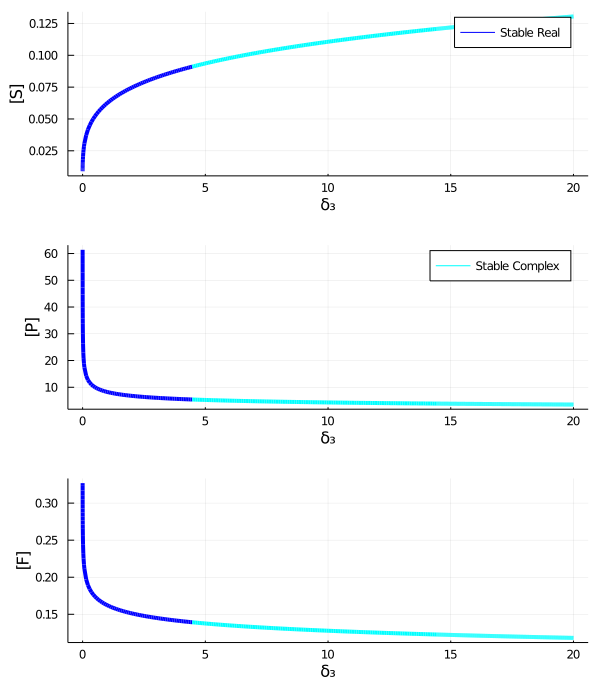

In [65]:
bif = bifurcations(rn, rnParam, :δ₃, (0.001,20.))
plt = plot(layout = (3,1), size = (600, 700))
plot!(plt, [[],[]],color=[:blue :cyan],label = ["Stable Real" "Stable Complex"])
plot!(plt[1], bif, 1, ylabel = "[S]")
plot!(plt[2], bif, 2, ylabel = "[P]")
plot!(plt[3], bif, 3, ylabel = "[F]")

# Variation of production rate of FGF10, or $\bar{\rho_F}$

The variation is from 10 to 200

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological

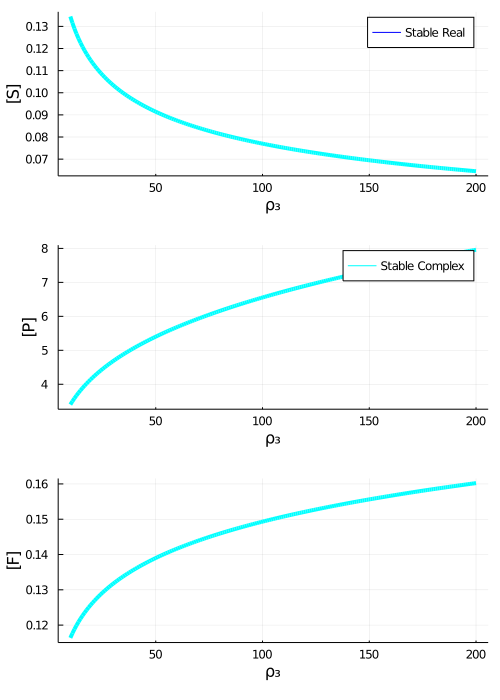

In [66]:
bif = bifurcations(rn, rnParam, :ρ₃, (10.0,200.0))
plt = plot(layout = (3,1), size = (500, 700))
plot!(plt[1], bif, 1, ylabel = "[S]")
plot!(plt[2], bif, 2, ylabel = "[P]")
plot!(plt[3], bif, 3, ylabel = "[F]")
plot!(plt, [[],[]],color=[:blue :cyan],label = ["Stable Real" "Stable Complex"])

## Variation of decay rate of complex SHH-Ptc, or $\bar{\delta_C}$

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram, ::Int64). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\hmngu\.julia\packages\Plots\hyS17\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological

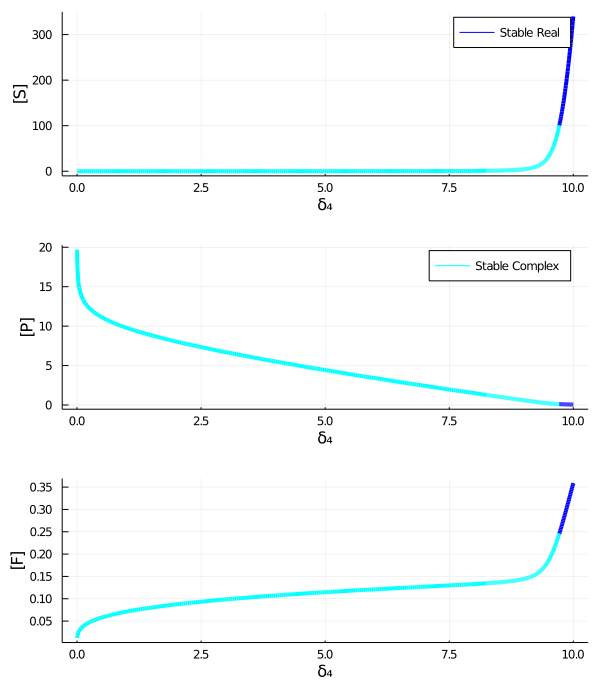

In [75]:
bif = bifurcations(rn, rnParam, :δ₄, (0.001,10.))
plt = plot(layout = (3,1), size = (600, 700))
plot!(plt, [[],[]],color=[:blue :cyan],label = ["Stable Real" "Stable Complex"])
plot!(plt[1], bif, 1, ylabel = "[S]")
plot!(plt[2], bif, 2, ylabel = "[P]")
plot!(plt[3], bif, 3, ylabel = "[F]")